# Dreambooth fine-tuning for Stable Diffusion using d🧨ffusers 

This notebook shows how to "teach" Stable Diffusion a new concept via Dreambooth using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

![Dreambooth Example](https://dreambooth.github.io/DreamBooth_files/teaser_static.jpg)
_By using just 3-5 images you can teach new concepts to Stable Diffusion and personalize the model on your own images_ 

Differently from Textual Inversion, this approach trains the whole model, which can yield better results to the cost of bigger models.

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



In [ ]:


!conda install -y -c conda-forge -c pytorch pytorch cudatoolkit=11.1

In [1]:
#@title Install the required libs
!pip install -qq diffusers==0.4.1 accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes

     |████████████████████████████████| 229 kB 28.5 MB/s 
     |████████████████████████████████| 148 kB 63.4 MB/s 
     |████████████████████████████████| 5.3 MB 57.7 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 11.6 MB 63.1 MB/s 
     |████████████████████████████████| 163 kB 46.6 MB/s 
     |████████████████████████████████| 7.6 MB 49.4 MB/s 
     |████████████████████████████████| 2.3 MB 56.0 MB/s 
     |████████████████████████████████| 106 kB 75.2 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 272 kB 72.2 MB/s 
     |████████████████████████████████| 212 kB 69.3 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |█████████████████████

In [2]:
#@title Login to the Hugging Face Hub
#@markdown Add a token with the "Write Access" role to be able to add your trained concept to the [Library of Concepts](https://huggingface.co/sd-dreambooth-library)
from huggingface_hub import notebook_login
!git config --global credential.helper store

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [3]:
#@title Import required libraries
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import bitsandbytes as bnb

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Settings for teaching your new concept

In [4]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

In [21]:
#@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
urls = [
      "https://petphotos.vercel.app/img/1.jpg",
      "https://petphotos.vercel.app/img/3.jpg",
      "https://petphotos.vercel.app/img/4.jpg",
      "https://petphotos.vercel.app/img/5.jpg",
      "https://petphotos.vercel.app/img/6.jpg",
      "https://petphotos.vercel.app/img/7.jpg",
      "https://petphotos.vercel.app/img/8.jpg",
      "https://petphotos.vercel.app/img/9.jpg",
      "https://petphotos.vercel.app/img/10.jpg",
      "https://petphotos.vercel.app/img/11.jpg",
       "https://petphotos.vercel.app/img/12.jpg",
        "https://petphotos.vercel.app/img/13.jpg",
         "https://petphotos.vercel.app/img/14.jpg",
          "https://petphotos.vercel.app/img/15.jpg",
           "https://petphotos.vercel.app/img/16.jpg",
         "https://petphotos.vercel.app/img/17.jpg"

      ## You can add additional images here
      ]

In [22]:
#@title Setup and check the images you have just added
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

In [7]:
#@title Settings for your newly created concept
#@markdown `instance_prompt` is a prompt that should contain a good description of what your object or style is, together with the initializer word `sks`  
instance_prompt = "a photo of sks shiba ricky" #@param {type:"string"}
#@markdown Check the `prior_preservation` option if you would like class of the concept (e.g.: toy, dog, painting) is guaranteed to be preserved. This increases the quality and helps with generalization at the cost of training time
prior_preservation = True #@param {type:"boolean"}
prior_preservation_class_prompt = "a photo of shiba ricky" #@param {type:"string"}

num_class_images = 12 
sample_batch_size = 2
prior_loss_weight = 0.5
prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder
class_prompt=prior_preservation_class_prompt

#### Advanced settings for prior preservation (optional)

In [8]:
num_class_images = 12 #@param {type: "number"}
sample_batch_size = 2
#@markdown `prior_preservation_weight` determins how strong the class for prior preservation should be 
prior_loss_weight = 1 #@param {type: "number"}


#@markdown If the `prior_preservation_class_folder` is empty, images for the class will be generated with the class prompt. Otherwise, fill this folder with images of items on the same class as your concept (but not images of the concept itself)
prior_preservation_class_folder = "./class_images" #@param {type:"string"}
class_data_root=prior_preservation_class_folder

## Teach the model the new concept (fine-tuning with Dreambooth)
Execute this this sequence of cells to run the training process. The whole process may take from 15 min to 2 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

In [9]:
#@title Setup the Classes
from pathlib import Path
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids
        
        return example


class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

In [10]:
#@title Generate Class Images
import gc
if(prior_preservation):
    class_images_dir = Path(class_data_root)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < num_class_images:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path, revision="fp16", torch_dtype=torch.float16
        ).to("cuda")
        pipeline.enable_attention_slicing()
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = num_class_images - cur_class_images
        print(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

        for example in tqdm(sample_dataloader, desc="Generating class images"):
            images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")
        pipeline = None
        gc.collect()
        del pipeline
        with torch.no_grad():
          torch.cuda.empty_cache()

In [12]:
#@title Load the Stable Diffusion model
#@markdown Please read and if you agree accept the LICENSE [here](https://huggingface.co/CompVis/stable-diffusion-v1-4) if you see an error
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

In [13]:
#@title Setting up all training args
from argparse import Namespace
args = Namespace(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    resolution=512,
    center_crop=True,
    instance_data_dir=save_path,
    instance_prompt=instance_prompt,
    learning_rate=5e-06,
    max_train_steps=450,
    train_batch_size=1,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="no", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation, 
    prior_loss_weight=prior_loss_weight,
    sample_batch_size=2,
    class_data_dir=prior_preservation_class_folder, 
    class_prompt=prior_preservation_class_prompt, 
    num_class_images=num_class_images, 
    output_dir="dreambooth-concept",
)

In [14]:
#@title Training function
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
    )
    
    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        # concat class and instance examples for prior preservation
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt").input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch
    
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)
  
    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                if args.with_prior_preservation:
                    # Chunk the noise and noise_pred into two parts and compute the loss on each part separately.
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    noise, noise_prior = torch.chunk(noise, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                    # Compute prior loss
                    prior_loss = F.mse_loss(noise_pred_prior, noise_prior, reduction="none").mean([1, 2, 3]).mean()

                    # Add the prior loss to the instance loss.
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()
    
    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(args.output_dir)

In [15]:
#@title Run training
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
with torch.no_grad():
    torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/450 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

## Run the code with your newly trained model
If you have just trained your model with the code above, use the block below to run it.

Also explore the [DreamBooth Concepts Library](https://huggingface.co/sd-dreambooth-library) 

In [ ]:
#@title Save your newly created concept? you may save it privately to your personal profile or collaborate to the [library of concepts](https://huggingface.co/sd-dreambooth-library)?
#@markdown If you wish your model to be avaliable for everyone, add it to the public library. If you prefer to use your model privately, add your own profile.

save_concept = True #@param {type:"boolean"}
#@markdown Once you save it you can use your concept by loading the model on any `from_pretrained` function
name_of_your_concept = "Cat toy" #@param {type:"string"}
where_to_save_concept = "public_library" #@param ["public_library", "privately_to_my_profile"]

#@markdown `hf_token_write`: leave blank if you logged in with a token with `write access` in the [Initial Setup](#scrollTo=KbzZ9xe6dWwf). If not, [go to your tokens settings and create a write access token](https://huggingface.co/settings/tokens)
hf_token_write = "" #@param {type:"string"}
if(save_concept):
  from slugify import slugify
  from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
  from huggingface_hub import create_repo
  from IPython.display import display_markdown
  api = HfApi()
  your_username = api.whoami()["name"]
  pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16,
  ).to("cuda")
  os.makedirs("fp16_model",exist_ok=True)
  pipe.save_pretrained("fp16_model")

  if(where_to_save_concept == "public_library"):
    repo_id = f"sd-dreambooth-library/{slugify(name_of_your_concept)}"
    #Join the Concepts Library organization if you aren't part of it already
    !curl -X POST -H 'Authorization: Bearer '$hf_token -H 'Content-Type: application/json' https://huggingface.co/organizations/sd-dreambooth-library/share/SSeOwppVCscfTEzFGQaqpfcjukVeNrKNHX
  else:
    repo_id = f"{your_username}/{slugify(name_of_your_concept)}"
  output_dir = args.output_dir
  if(not hf_token_write):
    with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();
  else:
    hf_token = hf_token_write 
  
  images_upload = os.listdir("my_concept")
  image_string = ""
  #repo_id = f"sd-dreambooth-library/{slugify(name_of_your_concept)}"
  for i, image in enumerate(images_upload):
      image_string = f'''{image_string}![image {i}](https://huggingface.co/{repo_id}/resolve/main/concept_images/{image})
'''
  readme_text = f'''---
license: mit
---
### {name_of_your_concept} on Stable Diffusion via Dreambooth
#### model by {api.whoami()["name"]}
This your the Stable Diffusion model fine-tuned the {name_of_your_concept} concept taught to Stable Diffusion with Dreambooth.
It can be used by modifying the `instance_prompt`: **{instance_prompt}**

You can also train your own concepts and upload them to the library by using [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb).
And you can run your new concept via `diffusers`: [Colab Notebook for Inference](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_inference.ipynb), [Spaces with the Public Concepts loaded](https://huggingface.co/spaces/sd-dreambooth-library/stable-diffusion-dreambooth-concepts)

Here are the images used for training this concept:
{image_string}
'''
  #Save the readme to a file
  readme_file = open("README.md", "w")
  readme_file.write(readme_text)
  readme_file.close()
  #Save the token identifier to a file
  text_file = open("token_identifier.txt", "w")
  text_file.write(instance_prompt)
  text_file.close()
  operations = [
    CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
    CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
  ]
  create_repo(repo_id,private=True, token=hf_token)
  
  api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message=f"Upload the concept {name_of_your_concept} embeds and token",
    token=hf_token
  )
  api.upload_folder(
    folder_path="fp16_model",
    path_in_repo="",
    repo_id=repo_id,
    token=hf_token
  )
  api.upload_folder(
    folder_path=save_path,
    path_in_repo="concept_images",
    repo_id=repo_id,
    token=hf_token
  )
display_markdown(f'''## Your concept was saved successfully. [Click here to access it](https://huggingface.co/{repo_id})
''', raw=True)

In [16]:
#@title Set up the pipeline 
try:
    pipe
except NameError:
    pipe = StableDiffusionPipeline.from_pretrained(
        args.output_dir,
        torch_dtype=torch.float16,
    ).to("cuda")

In [17]:
#@title Run the Stable Diffusion pipeline with interactive UI Demo on Gradio
#@markdown Run this cell to get an interactive demo where you can run the model using Gradio

#@markdown ![](https://i.imgur.com/2ACLWu2.png)
import gradio as gr

def inference(prompt, num_samples):
    all_images = [] 
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)
    return all_images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="prompt")
            samples = gr.Slider(label="Samples",value=1)
            run = gr.Button(value="Run")
        with gr.Column():
            gallery = gr.Gallery(show_label=False)

    run.click(inference, inputs=[prompt,samples], outputs=gallery)
    gr.Examples([["a photo of sks shiba inu in a suit", 1,1]], [prompt,samples], gallery, inference, cache_examples=False)


demo.launch()


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://143f550a53ce1979.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f65c81d3a50>,
 'http://127.0.0.1:7860/',
 'https://143f550a53ce1979.gradio.app')

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

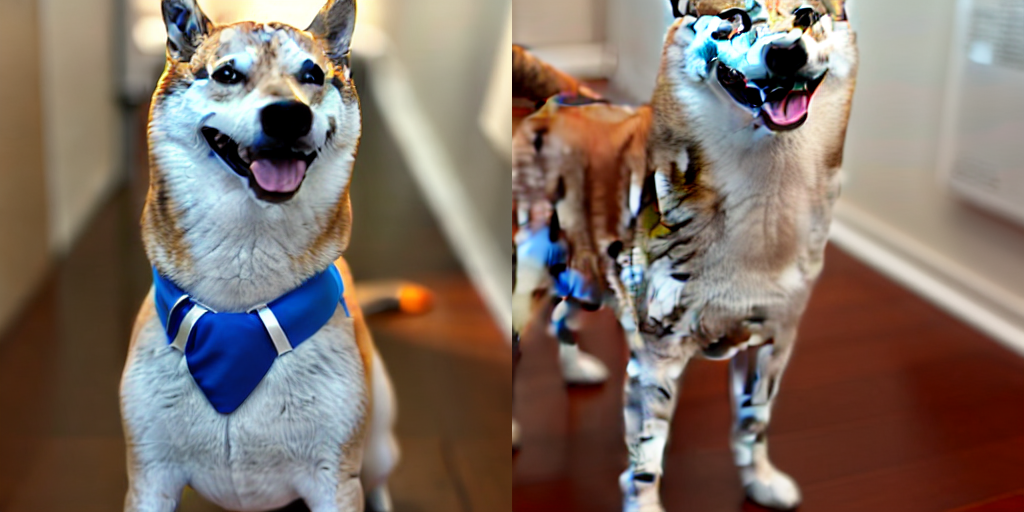

In [20]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "a photo of sks shiba inu in a suit" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid